The first cell is a copy of the demo.py that has been slightly modified to work in Jupyter notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from optigrid import optigrid
colors = ['black', 'brown', 'red', 'orange', 'yellow', 'green', 'blue', 'violet', 'gray', 'white']
n_points = 100

# First, generate two separate normal distributions and noise
normal1_mean = [-5, -5, 1]
normal1_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 0.05]]
normal1_samples = 10000
normal1 = np.random.multivariate_normal(mean=normal1_mean, cov=normal1_cov, size=normal1_samples)

normal2_mean = [5, 0, -1]
normal2_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 0.05]]
normal2_samples = 20000
normal2 = np.random.multivariate_normal(mean=normal2_mean, cov=normal2_cov, size=normal2_samples)

noise_low = [-10, -10, -10]
noise_high = [10, 10, 10]
noise_samples = 10000
noise = np.random.uniform(low=noise_low, high=noise_high, size=(noise_samples, 3))

data = np.concatenate((normal1, normal2))#, noise))

# Weight the samples from the first population twice as high
weights = np.array([2] * normal1_samples + [1] * normal2_samples)

# Now we want to standard scale our data. Although it is not necessary, it is recommended for better selection of the parameters and uniform importance of the dimensions.
data_scaled = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Next, chose the parameters
d = 3 # Number of dimensions
q = 1 # Number of cutting planes per step
noise_level = 0.1
max_cut_score = 0.3
bandwidth = 0.1

# Fit Optigrid to the data
optigrid_test = optigrid.Optigrid(d=d, q=q, max_cut_score=max_cut_score, noise_level=noise_level, kde_bandwidth=bandwidth, verbose=True)
optigrid_test.fit(data_scaled, weights=weights)
### Output: 
###     In current cluster: 47.08% of datapoints
###     In current cluster: 52.92% of datapoints
###     Optigrid found 2 clusters.

for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))
### Output: 
###     Cluster 0: Mean=[-5.03474967 -3.3355985   0.6569438 ], Std=[1.79700025 4.11403245 3.33377444]
###     Cluster 1: Mean=[ 4.92505754  0.05634452 -0.62898176], Std=[1.92237979 3.49116619 3.46671477]

# Draw a 10 values from both normals and score it with optigrid after normalization
sample_size = 10
sample1 = np.random.multivariate_normal(normal1_mean, normal1_cov, sample_size)
sample2 = np.random.multivariate_normal(normal2_mean, normal2_cov, sample_size)
sample = np.concatenate((sample1, sample2))
sample = (sample - np.mean(data)) / np.std(data)

result = optigrid_test.score_samples(sample)
print(result)
### Output: 
###     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
### The first ten values belong to the zeroth cluster and the latter ten to the second cluster as expected

min_val=-2.0938222295518143, max_val=1.6524085172963492
min_val=-2.5728330337767686, max_val=2.043601529800684
min_val=-1.6454328116756827, max_val=2.2040585881649055
Found following cuts: [(-0.35314935727893015, 0, 7.767300578613026e-05)]
Evaluating subgrid: 50.00% of datapoints
min_val=-2.1613834066867943, max_val=-0.592067514844862
min_val=-2.7263833933194905, max_val=0.2641980706270057
min_val=0.5610694838146804, max_val=2.3271356359665107
Found cluster 0: 50.00% of datapoints
Evaluating subgrid: 50.00% of datapoints
min_val=-0.08868022036931143, max_val=1.6524085172963492
min_val=-0.8222347824636931, max_val=2.043601529800684
min_val=-1.6454328116756827, max_val=0.38108897941571496
Found cluster 1: 50.00% of datapoints
Optigrid found 2 clusters.
Cluster 0: Mean=[-4.99214146 -4.98825957  1.00022352], Std=[1.00038052 1.00078336 0.22215139]
Cluster 1: Mean=[ 5.01113010e+00  2.92705980e-03 -1.00092059e+00], Std=[0.99328311 1.00809213 0.22567292]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,

This second cell modifies the demo.py to only look at 2-D data. The data set has also been modified to a 2-d data set.

In [2]:
import numpy as np
import matplotlib.pyplot as plt


from optigrid import optigrid


#random seed 42
np.random.seed(42)


# First, generate two separate normal distributions and noise
normal1_mean = [-5, -5]
normal1_cov = [[1, 0], [0, 1]]
normal1_samples = 10000
normal1 = np.random.multivariate_normal(mean=normal1_mean, cov=normal1_cov, size=normal1_samples)

normal2_mean = [5, 0]
normal2_cov = [[1, 0.2], [0.2, 1]]
normal2_samples = 20000
normal2 = np.random.multivariate_normal(mean=normal2_mean, cov=normal2_cov, size=normal2_samples)

normal3_mean = [0, 5]
normal3_cov = [[1, 0.2], [0.2, 1]]
normal3_samples = 20000
normal3 = np.random.multivariate_normal(mean=normal3_mean, cov=normal3_cov, size=normal3_samples)

normal4_mean = [-7, 20]
normal4_cov = [[1, 0.1], [.1, 1]]
normal4_samples = 20000
normal4 = np.random.multivariate_normal(mean=normal4_mean, cov=normal4_cov, size=normal4_samples)


noise_low = [-25, -25]
noise_high = [25, 25]
noise_samples = 1000
noise = np.random.uniform(low=noise_low, high=noise_high, size=(noise_samples, 2))

data = np.concatenate((normal1, normal2, normal3, normal4, noise))

# Weight the samples from the first population twice as high
weights = np.array([1] * normal1_samples + [1] * normal2_samples + [1] * normal3_samples + [1] * normal4_samples + [1] * noise_samples)

# Now we want to standard scale our data. Although it is not necessary, it is recommended for better selection of the parameters and uniform importance of the dimensions.
data_scaled = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Next, chose the parameters
d = 2 # Number of dimensions
q = 1 # Number of cutting planes per step
noise_level = 0.1
max_cut_score = 1
bandwidth = 0.2

# Fit Optigrid to the data
optigrid_test = optigrid.Optigrid(d=d, q=q, max_cut_score=max_cut_score, noise_level=noise_level, kde_bandwidth=bandwidth, verbose=False)
optigrid_test.fit(data_scaled, weights=weights)
### Output: 
###     In current cluster: 47.08% of datapoints
###     In current cluster: 52.92% of datapoints
###     Optigrid found 2 clusters.

for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))
### Output: 
###     Cluster 0: Mean=[-5.03474967 -3.3355985   0.6569438 ], Std=[1.79700025 4.11403245 3.33377444]
###     Cluster 1: Mean=[ 4.92505754  0.05634452 -0.62898176], Std=[1.92237979 3.49116619 3.46671477]

# Draw a 10 values from both normals and score it with optigrid after normalization
sample_size = 10
sample1 = np.random.multivariate_normal(normal1_mean, normal1_cov, sample_size)
sample2 = np.random.multivariate_normal(normal2_mean, normal2_cov, sample_size)
sample = np.concatenate((sample1, sample2))
sample = (sample - np.mean(data)) / np.std(data)

result = optigrid_test.score_samples(sample)
print(result)
### Output: 
###     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
### The first ten values belong to the zeroth cluster and the latter ten to the second cluster as expected

Cluster 0: Mean=[-5.30674848 -4.93183847], Std=[2.18826115 2.39365428]
Cluster 1: Mean=[-1.42261469e-03  4.86606104e+00], Std=[1.00196589 1.56515854]
Cluster 2: Mean=[ 5.17203765 -0.09052369], Std=[1.7611895  1.93386058]
Cluster 3: Mean=[-6.90218547 19.97316353], Std=[2.06304488 1.0766038 ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


This third cell plots the raw data then plots the clustered data with cutting planes.

The plot_cutting_planes function is designed to recursively traverse the GridLevel tree. When a leaf is encountered the defined cluster index is printed on the graph. When a branch is encountered, a plane is drawn.

Geometry is tracked and adjested for which side of the plane the each cut occured on so that the planes (lines) would begin on their root node and extend in the proper direction for the proper length.

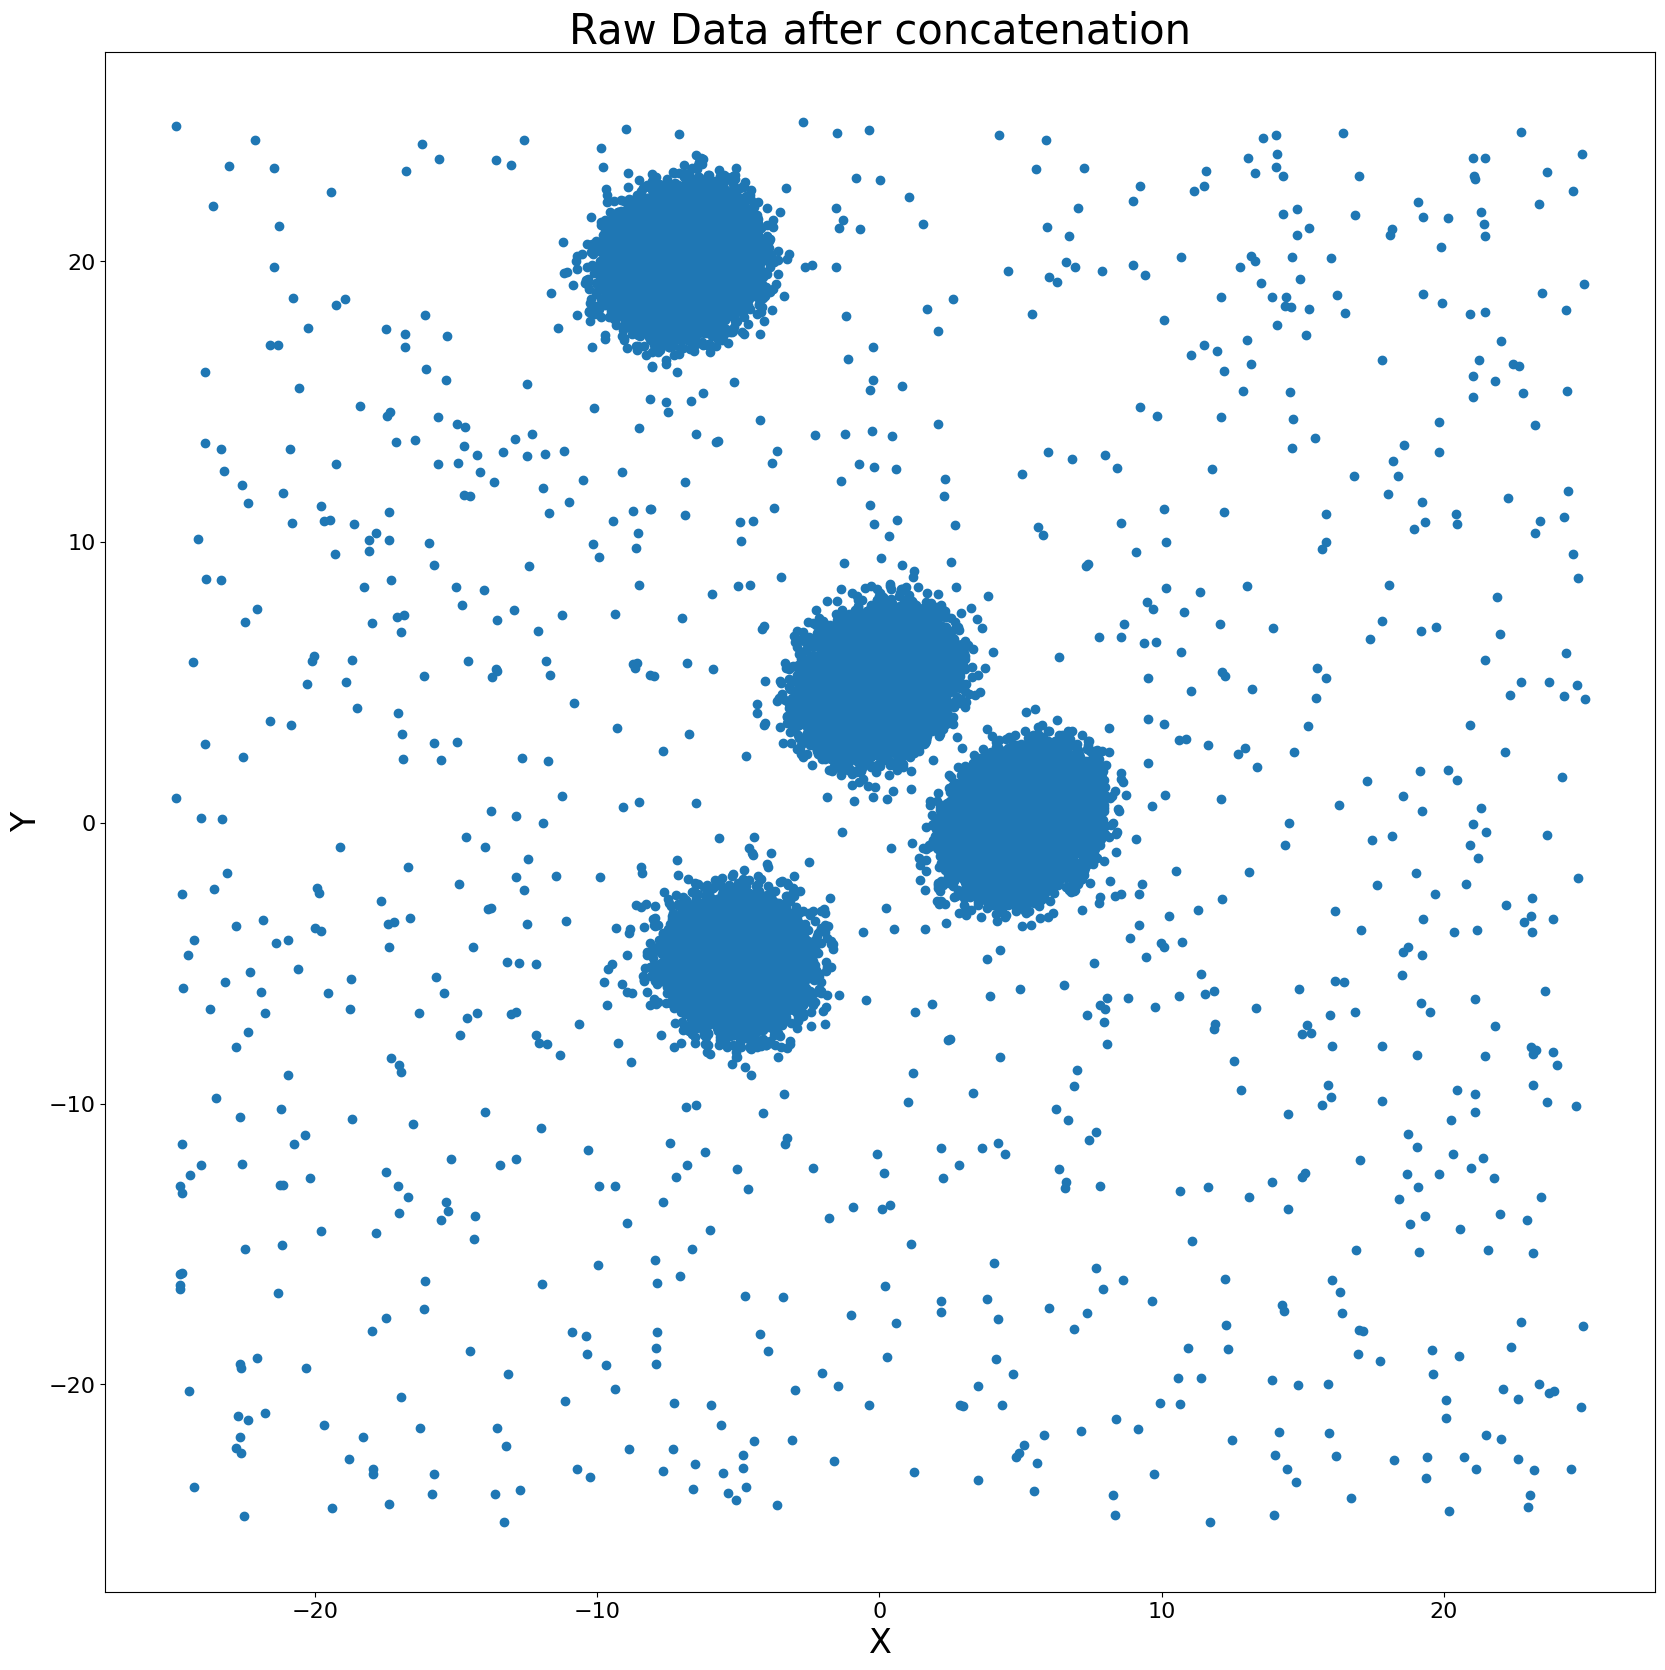

branch node - [(0.6767588285142767, 1, 0.004818754338053006)], side=-1, d_prev=-1, x0=-4.571, x1=5.072, y0=-3.352, y1=2.001
branch node - [(-0.282183815427306, 0, 0.125756342779702)], side=0, d_prev=1, x0=-4.571, x1=5.072, y0=-3.352, y1=0.677
leaf node - 0, side=0, d_prev=0, x0=-4.571, x1=-0.282, y0=-3.352, y1=0.677
branch node - [(0.7402296431389069, 0, 0.17762294245182766)], side=1, d_prev=0, x0=-0.282, x1=5.072, y0=-3.352, y1=0.677
leaf node - 1, side=0, d_prev=0, x0=-0.282, x1=0.740, y0=-3.352, y1=0.677
leaf node - 2, side=1, d_prev=0, x0=0.740, x1=5.072, y0=-3.352, y1=0.677
leaf node - 3, side=1, d_prev=1, x0=-4.571, x1=5.072, y0=0.677, y1=2.001


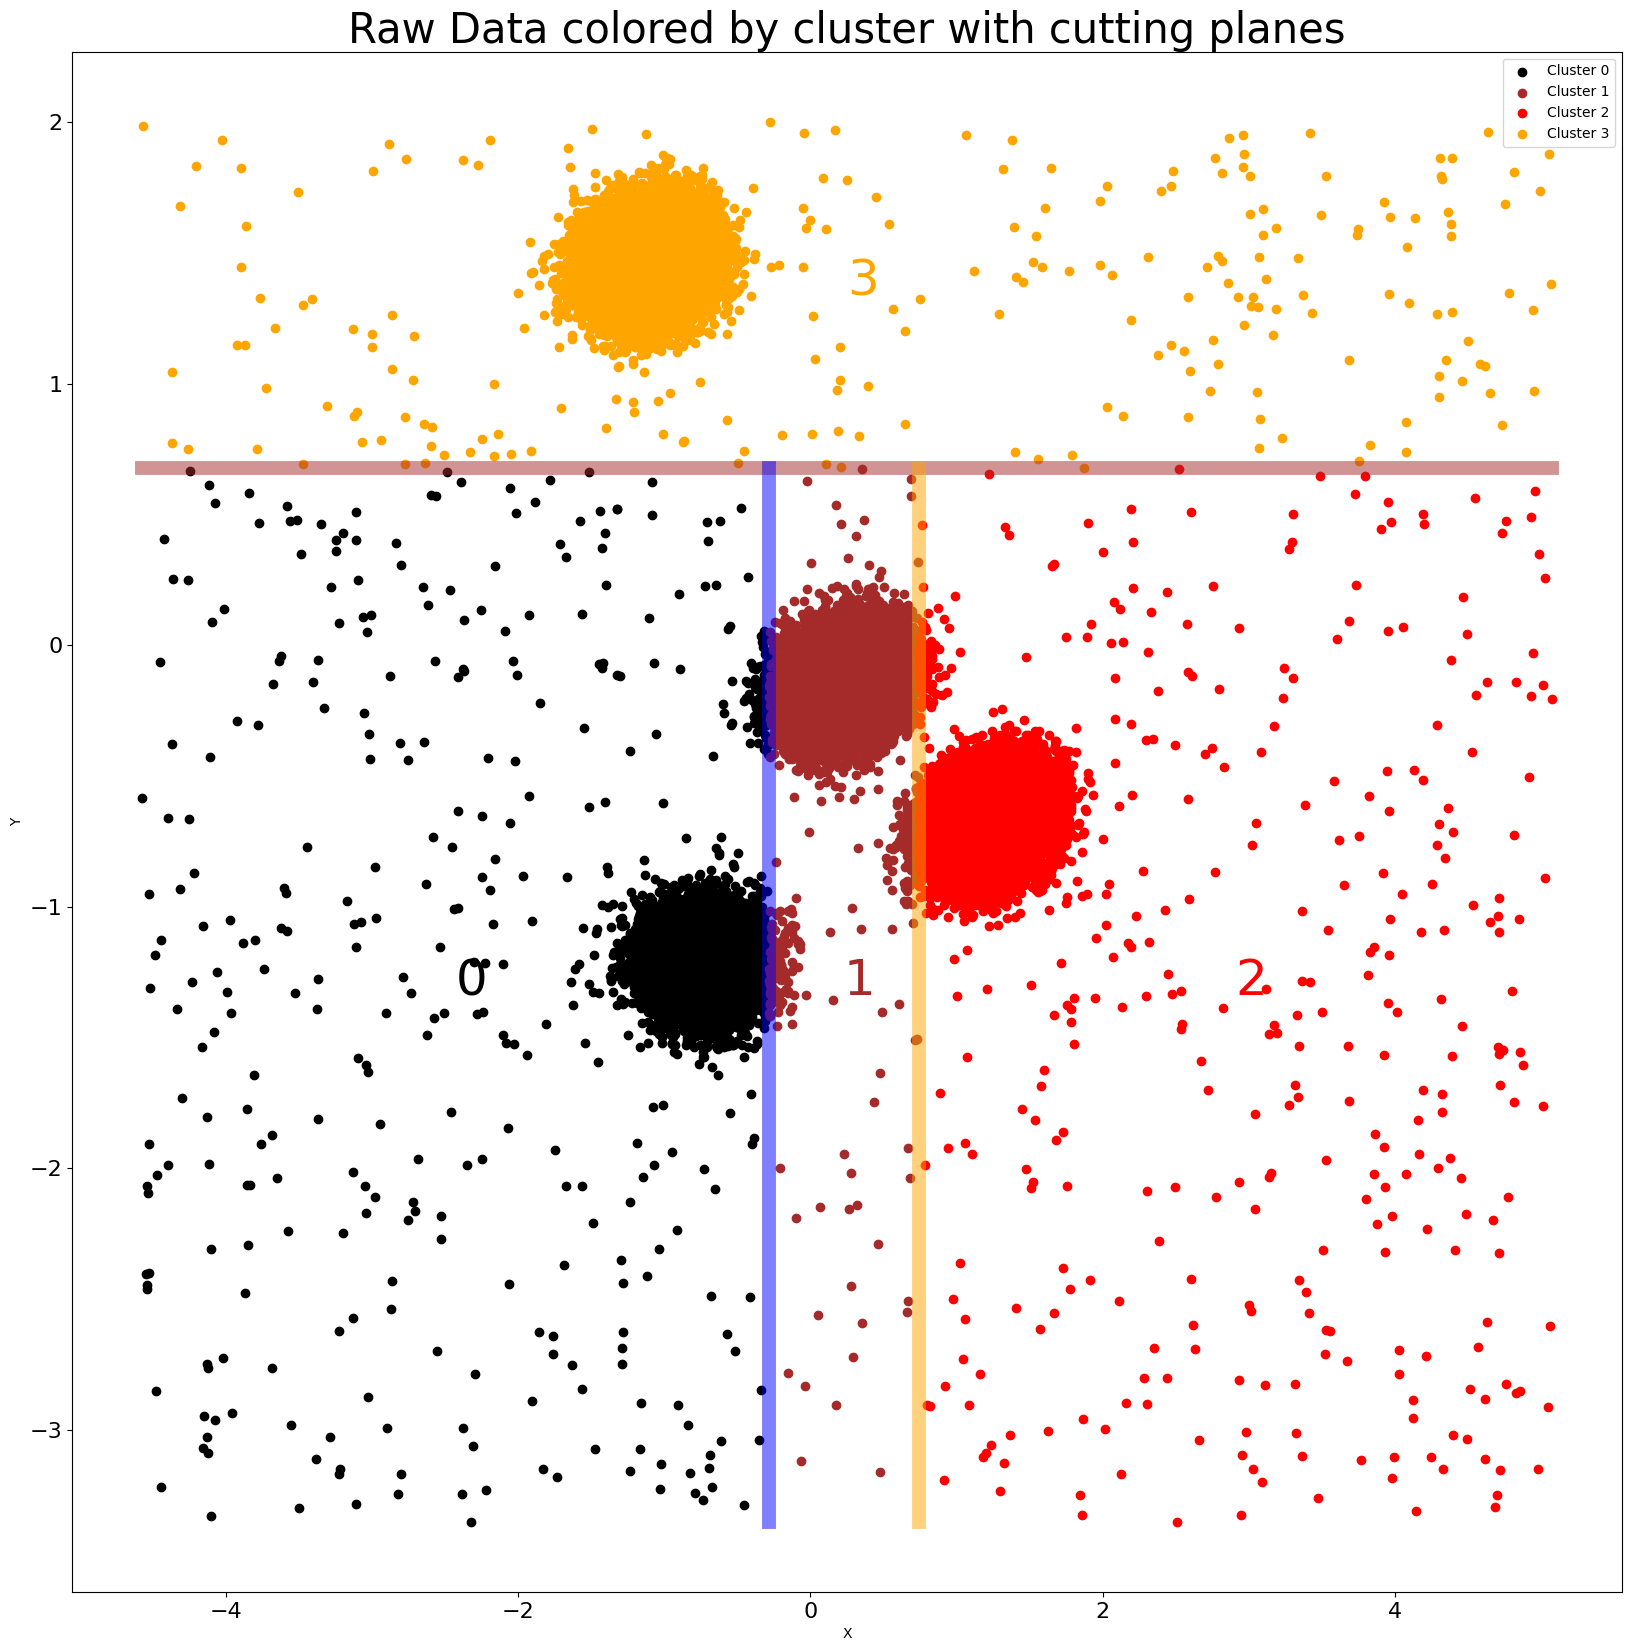

In [3]:

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.scatter(data[:,0], data[:,1])
ax.set_xlabel('X', fontsize=24)
#set x_label fontsize

ax.set_ylabel('Y', fontsize=24)

ax.title.set_text('Raw Data after concatenation')
ax.title.set_fontsize(30)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
for index, cluster in enumerate(optigrid_test.clusters):
    ax.scatter(data_scaled[cluster,0], data_scaled[cluster,1], label=f'Cluster {index}', color=colors[index%10])
ax.set_xlabel('X')
#set x_label fontsize
ax.set_ylabel('Y')
ax.legend()
ax.title.set_text('Raw Data colored by cluster with cutting planes')

#plot all cutting planes    
#recursively plot all cutting planes. Starting with the root node then traverse the tree to plot all cutting planes

def plot_cutting_planes(ax, node, side, d_prev, x0, x1, y0, y1):       
    if node is None:         
        return
        
    if  node.cutting_planes is None:
        print(f'leaf node - {node.cluster_index}, {side=}, {d_prev=}, {x0=:1.3f}, {x1=:1.3f}, {y0=:1.3f}, {y1=:1.3f}')
        ax.text((x0+x1)/2, (y0+y1)/2, f'{node.cluster_index}', color=colors[node.cluster_index%10], fontsize=36)      
        return
    else:
        print(f'branch node - {node.cutting_planes}, {side=}, {d_prev=}, {x0=:1.3f}, {x1=:1.3f}, {y0=:1.3f}, {y1=:1.3f}')
            
    for cutting_plane in node.cutting_planes:
        if cutting_plane[1] == 0:
            x = cutting_plane[0] * np.ones(n_points)
            y = np.linspace(y0, y1, n_points )
                        
            if side == 0: #left                
                ax.plot(x, y, alpha=0.5, c='blue', linewidth=10)
                #ax.text(x[0], (y0+y1)/2, f'{cutting_plane[0]:.1f}', color='black')
            else:
              
                ax.plot(x, y, alpha=0.5, c='orange', linewidth=10)
                #ax.text(x[0], (y0+y1)/2, f'{cutting_plane[0]:.1f}', color='red')

        elif cutting_plane[1] == 1:
            x =  np.linspace(x0, x1, n_points)
            y = cutting_plane[0] * np.ones(n_points)                                   
            
            if side == 0: #bottom              
                ax.plot(x, y, alpha=0.5, c='green', linewidth=10)
                #ax.text((x0+x1)/2, y[0], f'{cutting_plane[0]:.1f}', color='black')
            else:               
                ax.plot(x, y, alpha=0.5, c='brown', linewidth=10)
                #ax.text((x0+x1)/2, y[0], f'{cutting_plane[0]:.1f}', color='red')               
                  
            
        for child_side, child in enumerate(node.subgrids):
            if child_side == 0:
                if cutting_plane[1] == 0:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], x0, cutting_plane[0], y0, y1)
                elif cutting_plane[1] == 1:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], x0, x1, y0, cutting_plane[0])
            else:
                if cutting_plane[1] == 0:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], cutting_plane[0], x1, y0, y1)
                elif cutting_plane[1] == 1:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], x0, x1, cutting_plane[0], y1)
        
  
plot_cutting_planes(ax, optigrid_test.root, side=-1, d_prev=-1, x0=np.min(data_scaled[:,0]), x1=np.max(data_scaled[:,0]), y0=np.min(data_scaled[:,1]), y1=np.max(data_scaled[:,1]))
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.title.set_fontsize(30)

plt.show()

This cell generates 3d cluster data. There are three functions plus a 'main' body function. 

The algorithm works by generating cluster centers then populating and labelling the clusters.

The unlabelled data is graphed at the end of this cell.

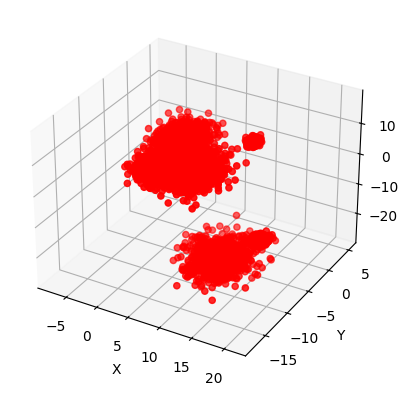

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import string
from sklearn.decomposition import PCA


def generate_cluster_centers(num_clusters, min_val, max_val):
    cluster_centers = np.random.uniform(min_val, max_val, size=(num_clusters, 3))    
    return cluster_centers

def generate_cluster_data(cluster_centers, num_points, mean_distance, std_dev, cluster_label_set=None, random_std= False, random_total_points=False):
    cluster_data = []
    labels = []


    for ix, center in enumerate(cluster_centers):
        
        if random_std == True:
            std_dev_distance = np.random.uniform(0, std_dev)
        else:
            std_dev_distance = std_dev
        
        if random_total_points==True:            
            total_points = np.random.randint(0, num_points)
        else:
            total_points = num_points

        points = np.random.normal(loc=center, scale=std_dev_distance, size=(total_points, 3))
        labels.extend([cluster_label_set[ix]] * total_points)
        cluster_data.append(points)
    return np.concatenate(cluster_data), labels

def generate_cluster_labels(num_clusters):
    alphabet = string.ascii_uppercase
    labels = []
    for i in range(num_clusters):
        if i < 26:
            label = alphabet[i]
        else:
            label = f"{alphabet[i % 26]}{i // 26}"
        labels.extend([label] )
    return labels



num_clusters = 7
min_val = -20   # min and max values for the cluster centers
max_val = 20
total_points = 1000
mean_distance = 9.0
std_dev_distance = 2

# Generate cluster labels
cluster_label_set = generate_cluster_labels(num_clusters)
cluster_centers = generate_cluster_centers(num_clusters, min_val, max_val)
cluster_data, cluster_labels = generate_cluster_data(cluster_centers, total_points, mean_distance, std_dev_distance, cluster_label_set,True, True)

# Plotting the clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


# Attach cluster labels to each datapoint
labeled_cluster_data = np.column_stack((cluster_data, cluster_labels))
raw_data = np.copy(cluster_data)


In this cell, the raw data is matched with generated labels then colorized. THe colorization matches the resistor color code for quick identification.

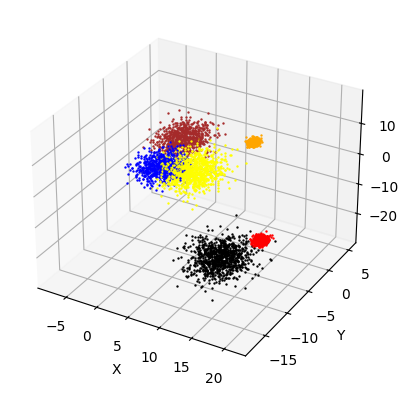

In [5]:
import matplotlib.pyplot as plt

# Define the resistor color code colors
colors = ['black', 'brown', 'red', 'orange', 'yellow', 'green', 'blue', 'violet', 'gray', 'white']

# Plotting the clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assign a unique color to each cluster
unique_labels = set(cluster_labels)
num_clusters = len(unique_labels)
#map colors to cluster labels by creating a dictionary
#loop through number of clusters and assign a color to each cluster using the colors list and cluster index mod 10
color_map = dict(zip(unique_labels, [colors[i % 10] for i in range(num_clusters)]))


# Plot each data point with its corresponding cluster color
for i, label in enumerate(cluster_labels):
    ax.scatter(cluster_data[i, 0], cluster_data[i, 1], cluster_data[i, 2], c=color_map[label], marker='o', s=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


This is the cell that calls OptiGrid.fit on the generated 3d data from above.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from optigrid import optigrid

# Weight the samples from the first population twice as high
weights = np.array([1] * cluster_data.shape[0])

# Now we want to standard scale our data. Although it is not necessary, it is recommended for better selection of the parameters and uniform importance of the dimensions.
cluster_data_scaled = (cluster_data - np.mean(cluster_data, axis=0)) / np.std(cluster_data, axis=0)

# Next, chose the parameters
d = 3 # Number of dimensions
q = 1 # Number of cutting planes per step
noise_level = 0.1
max_cut_score = 0.3
bandwidth = 0.1

# Fit Optigrid to the data
optigrid_test = optigrid.Optigrid(d=d, q=q, max_cut_score=max_cut_score, noise_level=noise_level, kde_bandwidth=bandwidth, verbose=True)
optigrid_test.fit(cluster_data_scaled, weights=weights)


for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data_i = np.take(cluster_data_scaled, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data_i, axis=0), np.std(cluster_data_i, axis=0)))


min_val=-2.94623915140963, max_val=1.6415368743891678
min_val=-1.9177055337068385, max_val=3.5100208223977596
min_val=-2.245205667645914, max_val=1.1623100184513175
Found following cuts: [(2.577987003672728, 1, 5.178975409563897e-11)]
Evaluating subgrid: 96.54% of datapoints
min_val=-1.764865747241432, max_val=1.6347652955118983
min_val=-2.0840151641641356, max_val=1.9424580253070627
min_val=-2.245205667645914, max_val=1.113477030556849
Found following cuts: [(-0.1417882202866081, 2, 1.0608172948082604e-05)]
Evaluating subgrid: 34.34% of datapoints
min_val=-0.6741439389821161, max_val=1.6347652955118983
min_val=-1.8875312080120992, max_val=1.2532152202776514
min_val=-2.245205667645914, max_val=-0.5656065291307388
Found following cuts: [(-1.040644669316849, 2, 0.003461738358815444)]
Evaluating subgrid: 18.18% of datapoints
min_val=-0.7353843615338214, max_val=1.3819540799928136
min_val=-1.8875312080120992, max_val=1.272714021113134
min_val=-2.245205667645914, max_val=-1.06556746101216
F

The following cell generates the 3d cutting planes. This is an extension of the plot_cutting_planes above. The primary difference is the generation of multiple 2-d vectors in order to plot the planes with appropriate geometry.

Each plane needs to set the propr dimension as a fixed value, then range across its bounding axes.

branch node - [(2.577987003672728, 1, 5.178975409563897e-11)], side=-1, d_prev=-1, x0=-2.964, x1=1.668, y0=-2.084, y1=3.510
branch node - [(-0.1417882202866081, 2, 1.0608172948082604e-05)], side=0, d_prev=1, x0=-2.964, x1=1.668, y0=-2.084, y1=2.578
branch node - [(-1.040644669316849, 2, 0.003461738358815444)], side=0, d_prev=2, x0=-2.964, x1=1.668, y0=-2.084, y1=2.578
leaf node - 0, side=0, d_prev=2, x0=-2.964, x1=1.668, y0=-2.084, y1=2.578, z0=-2.245, z1=-1.041
leaf node - 1, side=1, d_prev=2, x0=-2.964, x1=1.668, y0=-2.084, y1=2.578, z0=-1.041, z1=-0.142
branch node - [(-0.011199739372347084, 1, 0.06211322396468255)], side=1, d_prev=2, x0=-2.964, x1=1.668, y0=-2.084, y1=2.578
branch node - [(-0.5816813485603691, 0, 0.18380169172966956)], side=0, d_prev=1, x0=-2.964, x1=1.668, y0=-2.084, y1=-0.011
leaf node - 2, side=0, d_prev=0, x0=-2.964, x1=-0.582, y0=-2.084, y1=-0.011, z0=-0.142, z1=1.191
leaf node - 3, side=1, d_prev=0, x0=-0.582, x1=1.668, y0=-2.084, y1=-0.011, z0=-0.142, z1=1.1

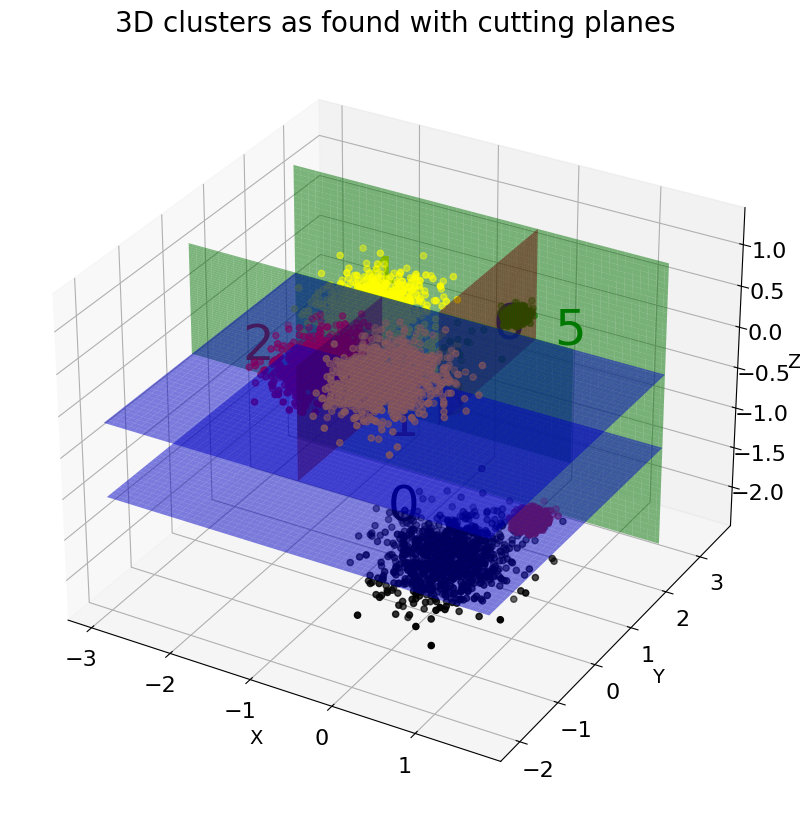

Animation movie is 22613437 bytes, exceeding the limit of 20971520.0. If you're sure you want a large animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB).


In [14]:
#create 3d plot of the data
%matplotlib inline
 
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.display import Image
from IPython.display import HTML
from datetime import datetime
matplotlib.rcParams['animation.embed_limit'] = 2**128

plane_colors = ['r', 'g', 'b']

def plot_cutting_planes_3d(ax, node, side, d_prev, x0, x1, y0, y1, z0, z1):       
    if node is None:         
        return
        
    if  node.cutting_planes is None:
        print(f'leaf node - {node.cluster_index}, {side=}, {d_prev=}, {x0=:1.3f}, {x1=:1.3f}, {y0=:1.3f}, {y1=:1.3f}, {z0=:1.3f}, {z1=:1.3f}')
        ax.text((x0+x1)/2, (y0+y1)/2, (z0+z1)/2, f'{node.cluster_index}', color=colors[node.cluster_index%10], fontsize=36)      
        return
    else:
        print(f'branch node - {node.cutting_planes}, {side=}, {d_prev=}, {x0=:1.3f}, {x1=:1.3f}, {y0=:1.3f}, {y1=:1.3f}')
            
    for cutting_plane in node.cutting_planes:
        if cutting_plane[1] == 0:
            x = cutting_plane[0] * np.ones((n_points, n_points))
            y = np.linspace(y0, y1, n_points)        
            z = np.linspace(z0, z1, n_points)            
            y, z = np.meshgrid(y, z)
        elif cutting_plane[1] == 1:
            x =  np.linspace(x0, x1, n_points)
            y = cutting_plane[0] * np.ones((n_points,n_points))        
            z = np.linspace(z0, z1, n_points)            
            x, z = np.meshgrid(x, z)            
        elif cutting_plane[1] == 2:
            x =  np.linspace(x0, x1, n_points)
            y = np.linspace(y0, y1, n_points)        
            z = cutting_plane[0] * np.ones((n_points,n_points))            
            x, y = np.meshgrid(x, y)
            
        
        ax.plot_surface(x, y, z, alpha=0.5, color=plane_colors[cutting_plane[1]])               
                  
            
        for child_side, child in enumerate(node.subgrids):
            if child_side == 0:
                if cutting_plane[1] == 0:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], x0, cutting_plane[0], y0, y1, z0, z1)
                elif cutting_plane[1] == 1:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], x0, x1, y0, cutting_plane[0], z0, z1)
                elif cutting_plane[1] == 2:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], x0, x1, y0, y1, z0, cutting_plane[0])            
            else:
                if cutting_plane[1] == 0:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], cutting_plane[0], x1, y0, y1, z0, z1)
                elif cutting_plane[1] == 1:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], x0, x1, cutting_plane[0], y1, z0, z1)
                elif cutting_plane[1] == 2:
                    plot_cutting_planes_3d(ax, child, child_side, cutting_plane[1], x0, x1, y0, y1, cutting_plane[0], z1)
        
  
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(cluster_data_scaled[:,0], cluster_data_scaled[:,1], cluster_data_scaled[:,2])
for index, cluster in enumerate(optigrid_test.clusters):
    ax.scatter(cluster_data_scaled[cluster,0], cluster_data_scaled[cluster,1], cluster_data_scaled[cluster,2], label=f'Cluster {index}', color=colors[index%10])
ax.set_xlabel('X', fontsize=14)
ax.tick_params(axis='x', labelsize=16)

ax.set_ylabel('Y', fontsize=14)
ax.tick_params(axis='y', labelsize=16)

ax.set_zlabel('Z', fontsize=14)
ax.tick_params(axis='z', labelsize=16)

ax.title.set_text('3D clusters as found with cutting planes')
ax.title.set_fontsize(20)


plot_cutting_planes_3d(ax, optigrid_test.root, side=-1, d_prev=-1, x0=np.min(cluster_data_scaled[:,0]), x1=np.max(cluster_data_scaled[:,0]), y0=np.min(cluster_data_scaled[:,1]), y1=np.max(cluster_data_scaled[:,1]), z0=np.min(cluster_data_scaled[:,2]), z1=np.max(cluster_data_scaled[:,2]))

#we will plot ax.plot_surface to show the cutting plane
#the dimension of the cutting plane is either the x plane, y plane or z plane which is determined by optigrid_test.root.cutting_plane[1]
#the fixed value in the dimension is determined by optigrid_test.root.cutting_plane[0]
#the range of the cutting plane is determined by optigrid_test.root.cutting_plane[2]

#rotate the plot to see the cutting planes



plt.show()
total_frames = 1270

def animate(frame):
    global total_frames    
    x0 = 10
    sections = 7 #number of sections to rotate around each axis
    x = (total_frames - x0)/sections
    
    if frame <= x0:
        ax.view_init(elev=30, azim=0, roll=0)

    #rotate around azimuth in X frames, holding the elevation and roll constant, ending at frame X0+X
    if frame > x0 and frame <= x0+x:
        #ax.view_init(elev=30, azim=(frame-x0)/2, roll=0)
        ax.view_init( azim=(frame-x0)*2)
    #rotate around elevation in X frames, holding the azimuth and roll constant, ending at frame X0+2*X
    if frame > x0+x and frame <= x0+2*x:
        #ax.view_init(elev=30+(frame-x0-x)/4, azim=(frame-x0)/4, roll=0)
        ax.view_init(elev=(frame-x0-x)*2)
    
    #rotate around roll in X frames, holding the azimuth and elevation constant, ending at frame X0+3*X
    if frame > x0+2*x and frame <= x0+3*x:
        ax.view_init(roll=(frame-x0-2*x)*2)
    
    #rotate around azimuth and elevation in X frames, holding the roll constant, ending at frame X0+4*X
    if frame > x0+3*x and frame <= x0+4*x:
        ax.view_init(elev=30+(frame-x0-3*x)*2, azim=(frame-x0-3*x)*2)
            
    #rotate around azimuth and roll in X frames, holding the elevation constant, ending at frame X0+5*X
    if frame > x0+4*x and frame <= x0+5*x:
        ax.view_init(azim=(frame-x0-4*x)*2, roll=(frame-x0-4*x)*2)
    
    #rotate around elevation and roll in X frames, holding the azimuth constant, ending at frameX0+6*X
    if frame > x0+5*x and frame <= x0+6*x:
        ax.view_init(elev=30+(frame-x0-5*x)*2, roll=(frame-x0-5*x)*2)
    
    #rotate around azimuth, elevation and roll in X frames, ending at frame X0+7*X
    if frame > x0+6*x and frame <= x0+7*x:
        ax.view_init(elev=30+(frame-x0-6*x)*2, azim=(frame-x0-6*x)*2, roll=(frame-x0-6*x)*2)
    
    #X0+7*X = 1270       
    plt.pause(.0005)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=total_frames, interval=50)
HTML(anim.to_html5_video())
#anim.save(os.path.normpath('./optigrid_3d_animation.mp4'))